In [1]:
from ipfnpytools.getsig import getsig
from ipfnpytools.ddelmsync import ddelmsync
from ipfnpytools.starkelmsync import starkelmsync
import dd
import matplotlib.cm as cm
import matplotlib.pylab as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as colors
import numpy as np
import os

#
#plt.style.use('helvet2')
#

In [2]:
def smooth(data,N=5):
    return np.convolve(data,np.ones(N)/N,'same');

def smooth2d(data,N):
    for i in range(len(data[0,:])):
        data[:,i] = smooth(data[:,i],N)
    return data

In [3]:
def three_starksync(shotnr, tBegin, tEnd, preft=0.002, suft=0.008,
                    refside='in', divside='in', divitem='jsat',
                    divertor_file=None,
                    minyval=2.1, maxyval=2.22,
                    mindens=0.5, maxdens=5.0,
                    felm_min=0, felm_max=1000,
                    ref_exper='AUGD', rdl_edition=0,
                    elm_exper='AUGD', elm_edition=0,
                    lettering=['(a)','(b)','(c)'],
                    dotsize=1.0,
                    minydiv=-5, maxydiv=20, divtickfreq=5,
                    vmax=20, vmaxdiv=5):

    """Ref, Divertor and Idiv data ELM Conditional Averaging
    Parameters:
    -----------
    shotnr: int
        Number of the discharge
    ti: float
        Inital time for analysis
    tf: float
        Final time for analysis
    preft: float
        Time in seconds before ELM onset to begin synchornisation
    suft: float
        Time in seconds after ELM end to finish synchronisation
    refside: str
        Either 'in' or 'out' for HFS or LFS system, respectively
    divside: str
        Either 'in' or 'out' for inner or outer divertor, respectively
    divitem: str
        Which measurement from the Langmuir probes to use.
    lettering: list of str
        Gives the option to choose the letter label for each plot for possible bash convert post-processing.
        
    Returns:
    ----------
    Nothing.
    """
    
    graphsets = {'minydiv': minydiv, 'maxydiv': maxydiv}
    
    ####Read Data
    ####Parameters for Refplot
    if refside == 'in':
        refsgr = "HFSR"
        separatrix_signal = "Rin"
        #minyval = 1.04
        #maxyval = 1.17
    else:
        refsgr = "LFSR"
        separatrix_signal = "Raus"
        #minyval = 2.14
        #maxyval = 2.26    

    #Get the array of densities in the shotfile 
    rdl = dd.shotfile('RDL', shotnr, edition=rdl_edition)
    auxne = rdl.getParameterSet('Aux', 'ne')
    dens = auxne['ne'].data*1e-19
    rdl.close()
    
    ##ELMsync RDL
    #th, rh = ddelmsync(shotnr, "RDL", refsgr, edition=rdl_edition, ti=ti, tf=tf,
    #                    preft=preft, suft=suft, elm_exper=elm_exper)

    th, rh = ddelmsync(shotnr, "RDL", refsgr, edition=rdl_edition, tBegin=tBegin, tEnd=tEnd,
                       preft=preft, suft=suft,
                       felm_min=felm_min, felm_max=felm_max,
                       elm_exper=elm_exper, elm_edition=elm_edition)
    
    ####ELMsync the Separatrix data
    trin, rin = ddelmsync(shotnr, "FPG", separatrix_signal, tBegin=tBegin, tEnd=tEnd,
                          preft=preft, suft=suft,
                          elm_exper=elm_exper, elm_edition=elm_edition)
    
    ####Divertor current
    if divside=='in':
        idivname = 'Ipolsoli'
        idivclr = 'r'
    else:   
        idivname = 'Ipolsola'
        idivclr = 'b'
 
    try:
        tidiv, idiv = ddelmsync(shotnr, "MAC", idivname, tBegin=tBegin, tEnd=tEnd,
                                preft=preft, suft=suft,
                                felm_min=felm_min, felm_max=felm_max,
                                elm_exper=elm_exper, elm_edition=elm_edition)
    except:#Auto replace with Dalpha
        if idivname == 'Ipolsoli':
            idivname = 'ELMi-Han'
        else:
            idivname = 'ELMa-Han'
        tidiv, idiv = ddelmsync(shotnr, "POT", idivname, tBegin=tBegin, tEnd=tEnd,
                                preft=preft, suft=suft,
                                felm_min=felm_min, felm_max=felm_max,
                                elm_exper=elm_exper, elm_edition=elm_edition)

        
    #tidiv = np.array([0,0])
    #idiv = np.array([0,0])
    
    ######Jsat
    t_Stark, DS_Stark, m_Stark = starkelmsync(shotnr, tBegin=tBegin, tEnd=tEnd,
                                              item=divitem, side=divside,
                                              preft=preft, suft=suft,
                                              felm_min=felm_min, felm_max=felm_max,
                                              elm_exper=elm_exper, elm_edition=elm_edition,
                                              file=divertor_file)        
    ######    
    fig = plt.figure(figsize=(3.0, 3.5), dpi=100)

    gs = mpl.gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1], width_ratios=[4, 1])
    
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
    ax3 = fig.add_subplot(gs[2, 0], sharex=ax1)
    
    if refside=='in':
        sidestr = ' HFS'
    else:
        sidestr = ' LFS'
    titlestr =  '#' + str(shotnr) + sidestr + ' t=[' + str(tBegin) +','+ str(tEnd) + '] s'
    ax1.set_title(titlestr, loc='left', fontsize=9)
    
    ax1.text(0.03, 0.85, lettering[0], transform = ax1.transAxes)
    ax2.text(0.03, 0.85, lettering[1], transform = ax2.transAxes, color='white')
    ax3.text(0.03, 0.85, lettering[2], transform = ax3.transAxes)

    ######################################
    indr = sorted(xrange(len(trin)), key=lambda ix: trin[ix])
    trinsort = trin[indr]
    rinsort = rin[indr]
    ax1.scatter(trin*1e3, rin, color='k', edgecolors='k', s=0.7)
    ax1.fill_between(trinsort*1e3, rinsort, 1.5, color='black', alpha=0.25)

    fth = []
    frh = []
    fne = []
    for i in range(len(dens)):
        if (dens[i]>=mindens)&(dens[i]<=maxdens):        
            fth.append(th)
            frh.append(rh[:,i])
            fne.append(np.ones_like(th)*dens[i])
        
    cfth = np.concatenate(fth)*1e3
    cfrh = np.concatenate(frh)
    cfne = np.concatenate(fne)
        
    ########
    cmap = cm.get_cmap('jet')
    sc = ax1.scatter(cfth, cfrh, c=cfne, s=dotsize, cmap=cmap)

    ###Colorbar
    axins = inset_axes(ax1,
                   width="5%", # width = 10% of parent_bbox width
                   height="100%", # height : 50%
                   loc=6,
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax1.transAxes,
                   borderpad=0,
               )    
    cbar = plt.colorbar(sc, cax=axins, ticks=(np.arange(0.0, max(cfne)+1.0, 1.0)))
    
    cbar.set_label(r'$\mathrm{n_{e}\,[10^{19}m^{-3}]}$')

    ax1.set_ylim([minyval, maxyval])

    #Inner wall
    ax1.hlines(1.045, -preft*1e3, suft*1e3, color='black', lw=3)
    
    ax1.set_ylabel(r"$\mathrm{R\,[m]}$")

    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)
    ######################################

    #Maximum vertical value for the emapping
    if divitem == 'nev':
        vmax = 80
        cbticks = np.linspace(20, vmax, 4)
        clblabelstr = "$\mathrm{n_{e,v}\,[10^{20}m^{-3}]}$"
    elif divitem == 'te':
        vmax = 20 #Limit it to 20eV
        cbticks = np.linspace(vmax/4, vmax, 4)
        clblabelstr = r"$\mathrm{t_{e}\,[eV]}$"
    elif divitem == 'net':
        vmax = np.min([24, np.floor(m.max())])
        cbticks = np.linspace(vmax/4, vmax, 4)
        clblabelstr = r"$\mathrm{n_{e,p}\,[10^{19}m^{-3}]}$"
    else: #Default to jsat        
        cbticks = np.linspace(0, vmax, vmaxdiv)
        clblabelstr = r"$\mathrm{\Gamma_{D^{+}}\,[10^{22}m^{-2}s^{-1}]}$"

    sc2 = ax2.pcolormesh(t_Stark*1e3, DS_Stark, m_Stark, shading='goraud', vmax=vmax, vmin=0.0, cmap=cmap)
    ###Colorbar    
    axins = inset_axes(ax2,
                   width="5%", # width = 10% of parent_bbox width
                   height="100%", # height : 50%
                   loc=6,
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax2.transAxes,
                   borderpad=0,
               )
    cbar = plt.colorbar(sc2, cax=axins, ticks=(np.arange(0.0, vmax+1.0, 5.0)))
    cbar.set_label(r"$\mathrm{\Gamma_{D^{+}}\,[10^{22}m^{-2}s^{-1}]}$")
        
    ax2.set_ylim([graphsets['minydiv'], graphsets['maxydiv']])
    ax2.set_xlim(-preft*1e3, suft*1e3)
    ax2.set_yticks((np.arange(minydiv, maxydiv+1.0, divtickfreq)))
    ax2.set_yticks((np.arange(graphsets['minydiv'], graphsets['minydiv']+1.0, divtickfreq)))
    ax2.set_yticks([-5,0,5,10,15,20])
    
    ax2.set_ylabel(r"$\mathrm{\Delta S\,[cm]}$")
    ax2.hlines(0, -preft*1e3, suft*1e3, color='white')

    ax2.set_xlim([-preft*1e3, suft*1e3])
    ######################################
    
    ax3.set_ylabel(r'$\mathrm{|I_{div}|\,[kA]}$')
    ax3.scatter(tidiv*1e3, np.abs(idiv*1e-3), color=idivclr, edgecolors=idivclr, s=0.7)
    ax3.set_ylim(0,25)
    ax3.set_yticks([0, 10, 20])
    ax3.set_xlabel(r"$\mathrm{t-t_{ELM}\,[ms]}$")
    if (suft+preft)*1e3>20:
        divxticks=5.0        
    elif ((suft+preft)*1e3>10) & ((suft+preft)*1e3<=20):
        divxticks=2.0
    elif ((suft+preft)*1e3>5) & ((suft+preft)*1e3<=10):
        divxticks=1.0
    else:
        divxticks=1.0
    ax3.set_xticks(np.arange(-preft*1e3, suft*1e3+1, divxticks))
    ax3.set_xlim([-preft*1e3, suft*1e3])
    ######################################
    
    plt.subplots_adjust(left=0.18, right=0.97, bottom=0.13, top=0.93, wspace=0.10, hspace=0.05)

    #Output file
    elmdir = os.path.expanduser('~') + "/ELM/"
    if not os.path.exists(elmdir):
        os.makedirs(elmdir)
    shotdir = elmdir + str(shotnr) + '/'
    if not os.path.exists(shotdir):
        os.makedirs(shotdir)
    
    def little_output(entry_time):
        return str(int(entry_time*1e3))

    filename =  "./Images/ssidiv_" + str(shotnr) + "_" + little_output(tBegin) + "_" + little_output(tEnd) + "_" + refside + divside + ".png"
    plt.savefig(filename, format="png", dpi=300)
    print("Wrote: " + filename)
    plt.show()

/afs/ipp/aug/ads-diags/common/python/lib/dd.py:118: RuntimeWarning: Warning by DDcsgnl (8.1): no calibration of data
  warnings.warn(err_txt, RuntimeWarning)
/afs/ipp/aug/ads-diags/common/python/lib/dd.py:118: RuntimeWarning: Warning by DDcsgrp (8.1): No PARAM_SET found
  warnings.warn(err_txt, RuntimeWarning)


Wrote: ./Images/ssidiv_30554_1800_2800_inin.png


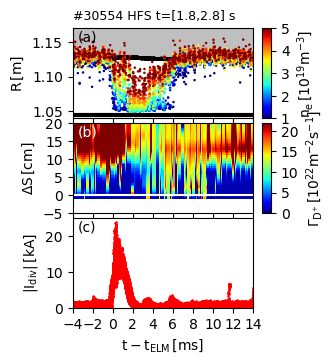

Wrote: ./Images/ssidiv_30554_1800_2800_outout.png


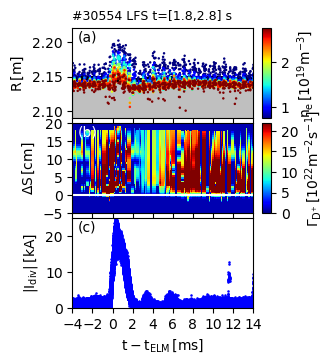

In [4]:
shotnr = 30554
ti = 1.8
tf = 2.8
preft = 0.004
suft = 0.014
three_starksync(shotnr, ti, tf, preft=preft, suft=suft, refside='in', divside='in', minyval=1.04, maxyval=1.17,
                lettering=['(a)','(b)','(c)'],
                elm_exper='guimas', elm_edition=1, mindens=0.5, maxdens=5.0, rdl_edition=1, vmax=22, dotsize=0.6,
                divertor_file='./Files/3D_30554_nev_in.dat')
three_starksync(shotnr, ti, tf, preft=preft, suft=suft, refside='out', divside='out', minyval=2.09, maxyval=2.22,
                lettering=['(a)','(b)','(c)'],
                elm_exper='guimas', elm_edition=1, mindens=0.5, maxdens=3.0, rdl_edition=0, vmax=22, dotsize=0.6,
                divertor_file='./Files/3D_30554_nev_out.dat')